In [103]:
from pprint import pprint

import dask.dataframe as dd
import networkx as nx
import networkit as nk
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

True

In [104]:
def parse_logs(s: str):
    safe_globals = {
        "__builtins__": {},
        "AttributeDict": lambda d: d,  # return the dict directly
        "HexBytes": lambda x: x,  # return the string argument
    }
    try:
        return eval(s, safe_globals)
    except Exception as e:
        print("Error parsing logs:", e)
        return []

In [105]:
dd_class1 = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "arbitrages_with_receipts.csv",
    dtype={
        "end_amount": "object",
        "error": "object",
        "profit_amount": "object",
        "start_amount": "object",
    },
)
dd_class1["receipt"] = dd_class1["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_class1["logs"] = dd_class1["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [106]:
dd_class0 = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_receipts.csv"
)
dd_class0["receipt"] = dd_class0["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_class0["logs"] = dd_class0["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [107]:
dd_class0["receipt"].head()

0    {'transactionHash': '0x8e90ecb85b61af368db0154...
1    {'transactionHash': '0xd83c25449d0766a18945f10...
2    {'transactionHash': '0x8b434ba680a93cc0e85a7c4...
3    {'transactionHash': '0x8d3b8e46a66a909643f2bb7...
4    {'transactionHash': '0x25908bad48b2353a1da142d...
Name: receipt, dtype: object

## Features edges

In [108]:
# See notebook 2.01-lte-signatures-arbitrages_with_logs.ipynb
top_class0_signatures = [
    "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef",
    "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925",
    "0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1",
    "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822",
    "0xe1fffcc4923d04b559f4d29a8bfc6cda04eb5b0d3c460751c2402c5c5cc9109c",
    "0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65",
    "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67",
    "0xe9149e1b5059238baed02fa659dbf4bd932fbcf760a431330df4d934bc942f37",
    "0x9d9af8e38d66c62e2c12f0225249fd9d721c54b83f48d9352c97c6cacdcb6f31",
    "0x17307eab39ab6107e8899845ad3d59bd9653f200f220920489ca2b5937696c31",
]

top_class1_signatures = [
    "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef",
    "0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1",
    "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822",
    "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67",
    "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925",
    "0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65",
    "0x19b47279256b2a23a1665c810c8d55a1758940ee09377d4f8d26497a3577dc83",
    "0x908fb5ee8f16c6bc9bc3690973819f32a4d4b10188134543c88706e0e1d43378",
    "0xddac40937f35385a34f721af292e5a83fc5b840f722bff57c2fc71adba708c48",
    "0x8201aa3f00000000000000000000000000000000000000000000000000000000",
]

top_signatures = list(set(top_class0_signatures + top_class1_signatures))

In [109]:
def extract_receipt_features(tx_receipt, top_signatures):
    features = {}
    features["transactionHash"] = tx_receipt.get("transactionHash")
    features["blockNumber"] = tx_receipt.get("blockNumber", 0)
    features["gasUsed"] = tx_receipt.get("gasUsed", 0)
    features["cumulativeGasUsed"] = tx_receipt.get("cumulativeGasUsed", 0)
    features["transactionIndex"] = tx_receipt.get("transactionIndex", 0)
    features["effectiveGasPrice"] = tx_receipt.get("effectiveGasPrice", 0)
    features["status"] = tx_receipt.get("status", 0)
    features["fee"] = features["gasUsed"] * features["effectiveGasPrice"]

    features["from"] = tx_receipt.get("from", None)
    features["to"] = tx_receipt.get("to", None)

    logs = tx_receipt.get("logs", [])
    features["num_logs"] = len(logs)

    event_counts = {}
    for log in logs:
        topics = log.get("topics", [])
        if topics:
            sig = topics[0].hex() if hasattr(topics[0], "hex") else str(topics[0])
            event_counts[sig] = event_counts.get(sig, 0) + 1

    for sig in top_signatures:
        features[f"dummy_{sig[:10]}"] = 1 if sig in event_counts else 0

    return features

In [110]:
dd_features_class0 = dd_class0["receipt"].apply(
    lambda row: extract_receipt_features(row, top_signatures),
    axis=0,
    meta=("features", "object"),
)
dd_features_class1 = dd_class1["receipt"].apply(
    lambda row: extract_receipt_features(row, top_signatures),
    axis=0,
    meta=("features", "object"),
)

In [111]:
features_class0 = dd_features_class0.compute()
features_class1 = dd_features_class1.compute()

In [112]:
df_features_class0 = pd.DataFrame(list(features_class0))
df_features_class1 = pd.DataFrame(list(features_class1))

In [113]:
df_features_class0["label"] = 0
df_features_class1["label"] = 1

In [114]:
df_features_edges = pd.concat([df_features_class0, df_features_class1])

In [115]:
df_features_edges.describe()

,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,num_logs,dummy_0xddf252ad,dummy_0xddac4093,...,dummy_0x908fb5ee,dummy_0x9d9af8e3,dummy_0x8201aa3f,dummy_0x8c5be1e5,dummy_0x1c411e9a,dummy_0xc42079f9,dummy_0x17307eab,dummy_0xe9149e1b,dummy_0x19b47279,label
count,2.284980e+05,2.284980e+05,2.284980e+05,228498.000000,2.284980e+05,228498.000000,2.284980e+05,228498.000000,228498.000000,228498.000000,...,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000
mean,1.714544e+07,1.638710e+05,5.497698e+06,54.450551,8.078694e+10,0.979435,1.556759e+16,6.103633,0.718886,0.003085,...,0.017142,0.010074,0.013720,0.083261,0.501265,0.387588,0.015107,0.001094,0.020915,0.496980
std,1.673162e+05,2.637874e+05,5.766008e+06,64.913711,3.166480e+11,0.141922,6.660117e+16,8.788783,0.449544,0.055460,...,0.129802,0.099865,0.116326,0.276277,0.499999,0.487201,0.121980,0.033059,0.143100,0.499992
min,1.695060e+07,2.100000e+04,2.100000e+04,0.000000,1.152221e+10,0.000000,3.150000e+14,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.699927e+07,4.710700e+04,1.171730e+06,6.000000,2.366379e+10,1.000000,1.540639e+15,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.708752e+07,1.400650e+05,3.328971e+06,27.000000,3.522781e+10,1.000000,4.939205e+15,6.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.727266e+07,2.057638e+05,8.167795e+06,89.000000,6.352686e+10,1.000000,1.196167e+16,8.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.751777e+07,2.402678e+07,2.999747e+07,910.000000,3.810702e+13,1.000000,7.302631e+18,960.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [116]:
df_features_edges.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x908fb5ee,dummy_0x9d9af8e3,dummy_0x8201aa3f,dummy_0x8c5be1e5,dummy_0x1c411e9a,dummy_0xc42079f9,dummy_0x17307eab,dummy_0xe9149e1b,dummy_0x19b47279,label
0,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...,17005294,153529,10750253,111,19150328915,1,2940130847991035,0x832aC338d06f5A438f3340B724c08C44e744e9c2,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,0,1,0,1,0,0,0,0,0,0
1,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...,16962424,123497,229900,1,139502435999,1,17228132338568503,0x080086911D8c78008800FAE75871a657b77d0082,0x0000E0Ca771e21bD00057F54A68C30D400000000,...,0,0,0,0,1,0,0,0,0,0
2,0x8b434ba680a93cc0e85a7c431e5b35a8efb60ef05c24...,16993741,21000,15838026,183,22098066562,1,464059397802000,0xE991Dc594Ea50b7B83be1B0a44Fd138582c04383,0xD8A5859Ce6f265D376922Dc27f70b804cc65f49E,...,0,0,0,0,0,0,0,0,0,0
3,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...,16972733,46817,14885776,165,18825121161,1,881335697394537,0xCA8ba7d3f798d1872A8C05c5358a1b24a4d3Ac64,0x2b591e99afE9f32eAA6214f7B7629768c40Eeb39,...,0,0,0,0,0,0,0,0,0,0
4,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...,17028487,32215,3160909,48,19660583885,1,633365709855275,0x8FEf490D614fCe8B93Bd6F28835dD35a8B3229a9,0xBA50933C268F567BDC86E1aC131BE072C6B0b71a,...,0,0,0,0,0,0,0,0,0,0


In [117]:
# nan values
df_features_edges.isna().sum()

transactionHash        0
blockNumber            0
gasUsed                0
cumulativeGasUsed      0
transactionIndex       0
effectiveGasPrice      0
status                 0
fee                    0
from                   0
to                   117
num_logs               0
dummy_0xddf252ad       0
dummy_0xddac4093       0
dummy_0x7fcf532c       0
dummy_0xe1fffcc4       0
dummy_0xd78ad95f       0
dummy_0x908fb5ee       0
dummy_0x9d9af8e3       0
dummy_0x8201aa3f       0
dummy_0x8c5be1e5       0
dummy_0x1c411e9a       0
dummy_0xc42079f9       0
dummy_0x17307eab       0
dummy_0xe9149e1b       0
dummy_0x19b47279       0
label                  0
dtype: int64

In [118]:
df_features_edges.dropna(inplace=True)

In [119]:
len(df_features_edges)

228381

In [120]:
df_features_edges["blockNumber"].max() - df_features_edges["blockNumber"].min()

567172

In [121]:
def plot_hist(df, label_name):
    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 6))
    ax = sns.histplot(df[label_name], bins=2, discrete=True)

    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    ax.set_xticks([0, 1])
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Count")
    ax.set_title("Histogram of Class Labels")

    plt.show()

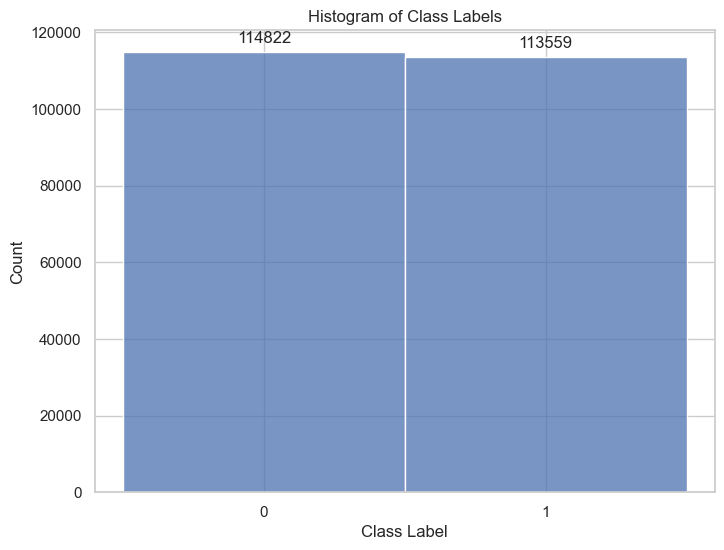

In [122]:
plot_hist(df_features_edges, "label")

In [123]:
# df_features.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges.csv", index=False
# )

## Features nodes

In [126]:
dummy_cols = [col for col in df_features_edges.columns if col.startswith("dummy_")]

agg_dict = {
    "gasUsed": ["mean"],
    "cumulativeGasUsed": ["mean"],
    "transactionIndex": ["min", "max", "mean"],
    "effectiveGasPrice": ["mean", "max"],
    "status": "mean",  # proportion of successful transactions
    "fee": ["mean"],
    "label": "max",  # If any transaction is arbitrage (1), then account is arbitrage
    "num_logs": ["min", "max", "mean"],    
}

for col in dummy_cols:
    agg_dict[col] = "mean"

df_accounts = df_features_edges.groupby("from").agg(agg_dict)

df_accounts.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col for col in df_accounts.columns.values
]

df_accounts = df_accounts.rename(
    columns={
        "label_max": "account_label",
    }
)

df_accounts = df_accounts.reset_index().rename(columns={"from": "account"})

In [127]:
df_accounts.head()

,account,gasUsed_mean,cumulativeGasUsed_mean,transactionIndex_min,transactionIndex_max,transactionIndex_mean,effectiveGasPrice_mean,effectiveGasPrice_max,status_mean,fee_mean,...,dummy_0xd78ad95f_mean,dummy_0x908fb5ee_mean,dummy_0x9d9af8e3_mean,dummy_0x8201aa3f_mean,dummy_0x8c5be1e5_mean,dummy_0x1c411e9a_mean,dummy_0xc42079f9_mean,dummy_0x17307eab_mean,dummy_0xe9149e1b_mean,dummy_0x19b47279_mean
0,0x00000000000124d994209fbB955E0217B5C2ECA1,101787.000000,3.744024e+06,3,48,21.272727,3.897291e+10,62912040686,0.818182,4.181177e+15,...,0.272727,0.0,0.0,0.0,0.272727,0.272727,0.454545,0.0,0.0,0.000000
1,0x000000000002e6fD89aC3B5798a5d32312B8a49f,21000.000000,9.850199e+06,123,123,123.000000,2.124601e+10,21246009046,1.000000,4.461662e+14,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,0x0000000000055772357E58581A2A2C5C6D9E8F64,184513.083333,2.028324e+06,0,94,12.666667,4.816098e+10,809819701570,1.000000,9.001021e+15,...,0.510417,0.0,0.0,0.0,0.000000,0.510417,0.968750,0.0,0.0,0.520833
3,0x00000000000FFE26043F4C963A16612f8410A881,132305.000000,1.212181e+07,147,147,147.000000,2.896867e+10,28968672309,1.000000,3.832700e+15,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000
4,0x0000000000E3C7175357AAE6FCE025bE01Aa13Ca,21000.000000,1.721499e+07,71,71,71.000000,1.552685e+11,155268454128,1.000000,3.260638e+15,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [128]:
len(df_accounts)

78656

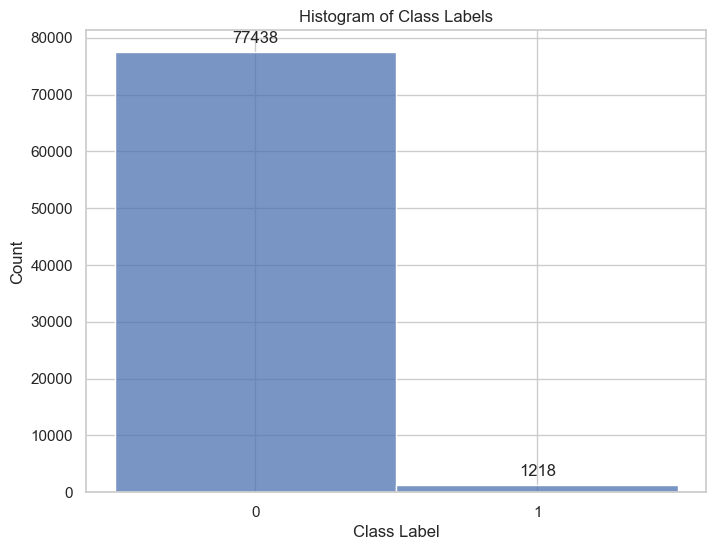

In [129]:
plot_hist(df_accounts, "account_label")

In [130]:
df_accounts.to_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_nodes_improved.csv", index=False
)

## Graph Features over all transactions

In [63]:
def add_graph_features(df):
    df_block = df.copy()

    G = nx.from_pandas_edgelist(df_block, source="from", target="to", create_using=nx.DiGraph())
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    G_undirected = G.to_undirected()
    clustering = nx.clustering(G_undirected)

    def common_neighbors_count(u, v):
        return len(list(nx.common_neighbors(G_undirected, u, v)))

    df_block["from_in_degree"] = df_block["from"].apply(lambda x: in_degrees.get(x, 0))
    df_block["from_out_degree"] = df_block["from"].apply(lambda x: out_degrees.get(x, 0))
    df_block["to_in_degree"] = df_block["to"].apply(lambda x: in_degrees.get(x, 0))
    df_block["to_out_degree"] = df_block["to"].apply(lambda x: out_degrees.get(x, 0))
    df_block["common_neighbors"] = df_block.apply(
        lambda row: common_neighbors_count(row["from"], row["to"]), axis=1
    )
    df_block["from_clustering"] = df_block["from"].apply(lambda x: clustering.get(x, 0))
    df_block["to_clustering"] = df_block["to"].apply(lambda x: clustering.get(x, 0))

    return df_block

In [ ]:
df_features_edges_graph = add_graph_features(df_features_edges)

In [ ]:
print(df_features_edges_graph.head())

In [65]:
# df_features_edges_graph.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_graph.csv", index=False
# )

## Graph Features per block

In [ ]:
df_edge_features_by_block = (
    df_features_edges_graph.groupby("blockNumber").apply(add_graph_features).reset_index(drop=True)
)

In [97]:
print(df_edge_features_by_block.head())

                                     transactionHash  blockNumber  gasUsed  \
0  0x5f7a16727b0ed026b1656924be454df15951fc3d1350...     16950601    21000   
1  0x4d419ef95a879f7d3da5ad7b55289ba88e360d5df7d4...     16950601    21000   
2  0x93211130eb153a9aafe8f6369f747e894750723a51c2...     16950601    21000   
3  0xf31afd603d349aa89be8b1380c7228d747fa754aac9f...     16950601    21000   
4  0xa89249328b426765357d02556f7f965b34b3d9c43065...     16950601    21000   

   cumulativeGasUsed  transactionIndex  effectiveGasPrice  status  \
0            4567366                57        19361969611       1   
1           22771101               327        18000000000       1   
2           25771997               379        18000000000       1   
3           21027553               302        18000000000       1   
4           14653779               216        18000000000       1   

               fee                                        from  \
0  406601361831000  0x8216874887415e2650D12D53Ff53

In [98]:
# df_edge_features_by_block.to_csv(config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_graph_by_block.csv", index=False)

## Graph Metrics

In [99]:
def compute_graph_metrics(G):
    simple_G = nx.DiGraph(G)

    density = nx.density(simple_G)

    avg_degree = (
        sum(dict(simple_G.degree()).values()) / simple_G.number_of_nodes()
        if simple_G.number_of_nodes() > 0
        else 0
    )

    clustering_coeff = nx.average_clustering(simple_G.to_undirected())

    components = list(nx.weakly_connected_components(simple_G))
    largest_component_size = max((len(c) for c in components), default=0)
    num_isolated_nodes = len(list(nx.isolates(simple_G)))

    degree_distribution = {}
    for node, degree in simple_G.degree():
        degree_distribution[degree] = degree_distribution.get(degree, 0) + 1

    return {
        "size": simple_G.number_of_nodes(),
        "density": density,
        "average_degree": avg_degree,
        "clustering_coefficient": clustering_coeff,
        "largest_component_size": largest_component_size,
        "num_isolated_nodes": num_isolated_nodes,
        "degree_distribution": degree_distribution,
    }

In [100]:
metrics = compute_graph_metrics(G)

In [101]:
pprint(metrics)

{'average_degree': 1.7626387725644634,
 'clustering_coefficient': 0.0008382579089858824,
 'degree_distribution': {1: 102060,
                         2: 6378,
                         3: 1453,
                         4: 651,
                         5: 310,
                         6: 212,
                         7: 155,
                         8: 105,
                         9: 85,
                         10: 74,
                         11: 55,
                         12: 45,
                         13: 43,
                         14: 42,
                         15: 28,
                         16: 32,
                         17: 33,
                         18: 22,
                         19: 21,
                         20: 16,
                         21: 21,
                         22: 17,
                         23: 10,
                         24: 9,
                         25: 9,
                         26: 12,
                         27: 10,
                  

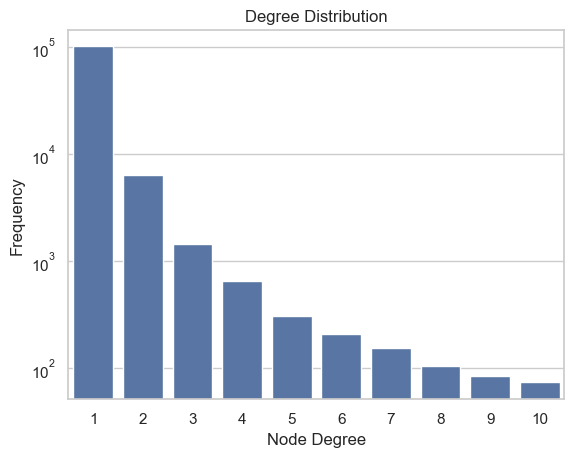

In [102]:
top_degrees = sorted(metrics["degree_distribution"].items(), key=lambda x: x[1], reverse=True)[:10]
sns.barplot(x=[d[0] for d in top_degrees], y=[d[1] for d in top_degrees])
plt.yscale("log")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()